In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
import math
from collections import OrderedDict

In [2]:
import matplotlib.pyplot as plt
# needs SciencePlots: https://github.com/garrettj403/SciencePlots 
plt.style.use('science')

In [3]:
def generate_dm_list(dm_start: float, dm_end: float, dt: float, ti: float, f0: float, df: float, nchans: int,
                     tol: float) -> list:
    """
    Code to generate Heimdall's DM list. 
    Original Source: https://github.com/thepetabyteproject/your/blob/master/your/utils/heimdall.py
    Taken from [dedisp](https://github.com/ajameson/dedisp/blob/master/src/kernels.cuh#L56)
    Based on: https://ui.adsabs.harvard.edu/abs/2012PhDT.......306L/abstract
    Args:
        dm_start (float): Start DM
        dm_end (float): End DM
        dt (float): Sampling interval (in seconds)
        ti (float): pulse width (in seconds)
        f0 (float): Center Frequency (MHz)
        df (float): Channel Bandwidth (MHz)
        nchans (int): Number of channels
        tol (float): Tolerance level
    Returns:
        list : List of DMs for which Heimdall will do the search
    """
    dt *= 1e6
#     ti *= 1e6
    center_freq = (f0 + (nchans / 2) * df) * 1e-3
    a = 8.3 * df / (center_freq ** 3)
    b = a ** 2 * nchans ** 2 / 16
    c = (dt ** 2 + ti ** 2) * (tol ** 2 - 1)

    dm_list = []
    dm_list.append(dm_start)
    while dm_list[-1] < dm_end:
        k = c + tol ** 2 * a ** 2 * dm_list[-1] ** 2
        dm = (
            b * dm_list[-1]
            + math.sqrt(-(a ** 2) * b * dm_list[-1] ** 2 + (a ** 2 + b) * k)
        ) / (a ** 2 + b)
        dm_list.append(dm)
    return dm_list

In [4]:
def get_decimation_dm(tsamp, foff, fch1, factor: int = 2) -> float:
    return (
        factor
        * tsamp
        / np.abs(8.3e-6 * foff / (fch1 * 1e-3) ** 3)
    )

In [5]:
# Set Realfast L band search configuration 

dm_start = 0
dm_end = 3000
tsamp = 0.005 #s
ti_in = 0.03 #s
f0 = 1500 #1440 #1920 #MHz
fch1 = 2000
bw = 1000
nchans = 256
df = -1*bw/nchans
tol = (100/95)**2 # 5% sensitivity loss accross DM trials 
max_width = np.ceil(np.log2(30*1e-3//tsamp)) # log2(samples)
boxcar_widths = 2**np.linspace(0, max_width, max_width+1)*tsamp #sec

In [6]:
boxcar_widths

array([0.005, 0.01 , 0.02 , 0.04 ])

In [7]:
iterations = int(np.ceil(dm_end / get_decimation_dm(tsamp, df, f0)))

In [8]:
plan = OrderedDict()

In [9]:
n_dms = 0
for i in range(iterations):
    dm_end = (i + 1) * get_decimation_dm(tsamp, df, f0, 2)
    out_list = generate_dm_list(
        dm_start,
        dm_end,
        (2 ** i) * tsamp,
        ti_in,
        f0,
        df,
        nchans,
        tol,
    )
    plan[2 ** i] = out_list 
    n_dms += len(out_list)
    dm_start = out_list[-1]

In [10]:
n = 0
dms = []
for k in plan.keys():
    dms += plan[k]
    print(k, plan[k][-1], len(plan[k]))

1 1046.1864391772122 361
2 2090.0452081615895 95
4 3141.2468039023074 56


In [11]:
dm_trials = np.array(dms)
boxcar_trials = boxcar_widths #sec

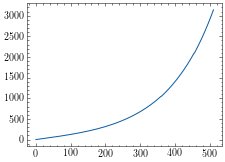

In [12]:
plt.plot(dm_trials)

In [13]:
len(dm_trials), f0, df

(512, 1500, -3.90625)

In [14]:
def get_n_cands(cand_width, cand_dm, cand_snr, dm_trials, boxcar_trials, 
                tsamp, f0, df, nchans, ret_arr=False):
    snr_th = 8
    tscatter = 0
    center_freq = f0/1000 #GHz
    chan_bw = df
    tdm = (10**(-6))*8.3*chan_bw*cand_dm/(center_freq**3) #sec
    tddm = (10**(-6))*(8.3/4)*nchans*chan_bw*(dm_trials-cand_dm)/(center_freq**3) #sec
    
    weff_dm = np.sqrt(tscatter**2 + tsamp**2 + cand_width**2 + tdm**2 + tddm**2)
    dm_loss_factor = (cand_width/weff_dm)**(1/2)

    width_loss_factor = []
    for b in boxcar_trials:
        ratio = weff_dm/b
        ratio[ratio < 1] = 1/ratio[ratio < 1] #inverting the ones less than 1 
        width_loss_factor.append(1/ratio**(1/2))
        
    width_loss_factor = np.array(width_loss_factor)
#     snrs = cand_snr*dm_loss_factor
    snrs_final = cand_snr*dm_loss_factor*width_loss_factor
    n_cands_wrt_boxcar_width = (snrs_final > snr_th).sum(1)
    n_tot = np.sum(n_cands_wrt_boxcar_width)
    if ret_arr:
        return n_tot, snrs_final
    else:
        return n_tot

In [15]:
snrs = np.array([8, 10, 20, 50, 70, 100])

In [16]:
n_1000_1 = []
n_100_1 = []
n_1000_10 = []
n_100_10 = []

for snr in snrs:
    n_1000_1.append(get_n_cands(cand_width=1*10**(-3), cand_dm=1000, cand_snr=snr, 
                                      dm_trials=dm_trials, boxcar_trials=boxcar_trials, 
                                      tsamp=tsamp, f0=f0, df=df, nchans=nchans, ret_arr=False))
    n_1000_10.append(get_n_cands(cand_width=10*10**(-3), cand_dm=1000, cand_snr=snr, 
                                  dm_trials=dm_trials, boxcar_trials=boxcar_trials, 
                                  tsamp=tsamp, f0=f0, df=df, nchans=nchans, ret_arr=False))
    n_100_1.append(get_n_cands(cand_width=1*10**(-3), cand_dm=100, cand_snr=snr, 
                              dm_trials=dm_trials, boxcar_trials=boxcar_trials, 
                              tsamp=tsamp, f0=f0, df=df, nchans=nchans, ret_arr=False))
    n_100_10.append(get_n_cands(cand_width=10*10**(-3), cand_dm=100, cand_snr=snr, 
                          dm_trials=dm_trials, boxcar_trials=boxcar_trials, 
                          tsamp=tsamp, f0=f0, df=df, nchans=nchans, ret_arr=False))

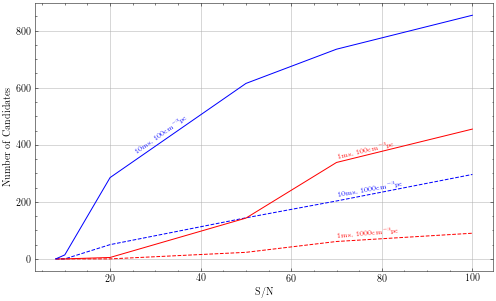

In [17]:
plt.figure(figsize=(2*3.5500029749550297, 2*2.19402249868545))

plt.plot(snrs, n_1000_1, label=r'Width=1ms, DM=1000cm$^{-3}$pc', linestyle='--', color='r')
plt.plot(snrs, n_1000_10, label=r'Width=10ms, DM=1000cm$^{-3}$pc', linestyle='--', color='b')
plt.plot(snrs, n_100_1, label=r'Width=1ms, DM=100cm$^{-3}$pc', color='r')
plt.plot(snrs, n_100_10, label=r'Width=10ms, DM=100cm$^{-3}$pc', color='b')

size = 7

x = 25 
y = 370
plt.text(x, y, r'10ms, 100cm$^{-3}$pc', color='b', fontsize=size, rotation=35)

x = 70 
y = 355
plt.text(x, y, r'1ms, 100cm$^{-3}$pc', color='r', fontsize=size, rotation=13)

x = 70 
y = 220
plt.text(x, y, r'10ms, 1000cm$^{-3}$pc', color='b', fontsize=size, rotation=10)

x = 70 
y = 75
plt.text(x, y, r'1ms, 1000cm$^{-3}$pc', color='r', fontsize=size, rotation=5)


plt.ylabel('Number of Candidates')
plt.xlabel('S/N')
plt.grid()
plt.tight_layout()
# plt.savefig('ncands_vs_snr_new.pdf', bbox_inches='tight')